# Electricity estimations

This builds from the 2016-02-17-daily-predicted-use notebook.

I'd like to understand the contributions to the total energy use from the different end uses.

We start by collecting statistics on valid survey responses to appliance questions.
We then filter for usage responses that don't make sense (over 7 times a week, more than 24 hours per day).

TODO:

- report initial quality of data for completeness and implausible values
- is it possible to visualize as a huge heat map?
- filter outliers or bad hours per week numbers ()
- why are all counts 1184, shouldn't there be nulls?
- are we averaging in zeros that should be nulls?
- why isn't the survey preventing hours and per week responses if you don't have the appliance?
- do the energy averages omit the null values?
- how many responses own but no usage?
- how many responses usage but don't own?  do we have skip logic that prevents this?
- table rows are appliances
- columns are number owning, number not owning, number not responding, 
- number answering week, number answering hours, number not responding

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pysentani as sti
survey = pd.read_excel('../data-survey/sentani-merged-cleaned-2015-06-10.xlsx')
survey['access_type'] = sti.access_type(survey)

There are only 12 surveys that answer all questions about appliance usage.

What about on a per appliance basis?

In [2]:
columns = []
for app in ['TV', 'radio', 'fridge', 'fan', 'rice_cooker', 'lighting']:
    # generate column labels for each appliance
    columns.append('app_now/{}'.format(app))
    columns.append('app_{}_per_wk'.format(app))
    columns.append('app_{}_hrs'.format(app))

# TODO: drill down into where the nulls are and are they correlated with appliance ownership or not?
# how many report owning the appliance but don't report usage?
# haven't we looked at this before?  matt rosi's work?

anynulls = survey[columns].isnull().any(axis=1)
allnulls = survey[columns].isnull().all(axis=1)
nonulls = survey[columns].notnull().all(axis=1)

# if any and all are the same series, then there are no surveys with some nulls
print('any and all nulls equal?', anynulls.equals(allnulls))

print(anynulls.value_counts())
print(allnulls.value_counts())
print(nonulls.value_counts())

any and all nulls equal? False
True     1172
False      12
dtype: int64
False    1035
True      149
dtype: int64
False    1172
True       12
dtype: int64


Below we determine how many households have compliant responses for appliance usage (hours per day and days per week) for each appliance.
We count the households who have non-null responses for each appliance type and join this with the counts of ownership in a table.


In [3]:
own_dict = {}
use_dict = {}

for app in ['TV', 'radio', 'fridge', 'fan', 'rice_cooker', 'lighting']:
    columns = []
    # generate column labels for each appliance
    own = 'app_now/{}'.format(app)
    use = ['app_{}_per_wk'.format(app), 'app_{}_hrs'.format(app)]
    
    print(app)
    #print(nonulls.value_counts())
    
    #print(survey[own].value_counts(dropna=False))
    own_dict[app] = survey[own].value_counts(dropna=False)
    
    # true values means households owning appliances reported usage numbers
    # print(survey[survey[own]==1][use].notnull().all(axis=1).value_counts())
    use_dict[app] = survey[survey[own]==1][use].notnull().all(axis=1).value_counts()

TV
radio
fridge
fan
rice_cooker
lighting


In [4]:
own = pd.DataFrame(own_dict).T
own

,0.0,1.0,nan
TV,191,844,149
fan,905,130,149
fridge,837,198,149
lighting,84,951,149
radio,683,352,149
rice_cooker,861,174,149


In [5]:
use = pd.DataFrame(use_dict).T
use

,True,False
TV,810,34
fan,127,3
fridge,193,5
lighting,926,25
radio,340,12
rice_cooker,169,5


We see that the fraction of households owning an appliance that are reporting hours is over 95% for all appliance types.
We assume that the population that did not report valid usage is similar to the population reporting.

In [6]:
# merge two data frames and give meaningful column names
usage_responses = pd.merge(own, use, right_index=True, left_index=True)
usage_responses['reporting_fraction'] = usage_responses['True_y']/usage_responses['1.0_x']
usage_responses = usage_responses.rename(columns={'1.0_x':'Owning Households',
                                                  'True_y':'Owning and Valid Usage'})
usage_responses[['Owning Households', 'Owning and Valid Usage']]

,Owning Households,Owning and Valid Usage
TV,844,810
fan,130,127
fridge,198,193
lighting,951,926
radio,352,340
rice_cooker,174,169


# Filtering outlier usage responses

There are some responses currently in the survey that report use above 24 hours per day or more than 7 days per week.  For now if these exceed the maximum, I'm replacing with the maximum.  We may want to clean the data set and repost a new version.

When we filter the data, we have to account for the presence of null values.

In [7]:
for app in ['TV', 'radio', 'fridge', 'fan', 'rice_cooker', 'lighting']:
    # generate column labels for each appliance
    wk_col = 'app_{}_per_wk'.format(app)
    hr_col = 'app_{}_hrs'.format(app)
    # if null or within range use value, otherwise use max possible value
    survey[hr_col] = survey[hr_col].where(survey[hr_col].isnull() | (survey[hr_col] <= 24), 24)
    survey[wk_col] = survey[wk_col].where(survey[wk_col].isnull() | (survey[wk_col] <= 7), 7)

    # ensure non-null values are within bounds
    assert(all(survey[wk_col].dropna() <= 7))
    assert(all(survey[wk_col].dropna() >= 0))
    assert(all(survey[hr_col].dropna() <= 24))
    assert(all(survey[hr_col].dropna() >= 0))

We use these hourly ranges to estimate the electricity use for each appliance type.

$$ \textrm{daily energy (kWh)} = \left(\frac{use\ times\ per\ week * hours\ per\ use}{7}\right)power(kW)$$

The power assumptions are below.

In [8]:
powers = {'TV':0.040, 
          'fridge':0.100, 
          'radio':0.010, 
          'fan':0.050, 
          'rice_cooker':0.350, 
          'lighting':0.050}
pd.DataFrame({'power (kW)':powers})

,power (kW)
TV,0.04
fan,0.05
fridge,0.10
lighting,0.05
radio,0.01
rice_cooker,0.35


In [9]:
appliance_list = ['TV', 'fridge', 'radio', 'fan', 'rice_cooker', 'lighting']

for appliance in appliance_list:
    # create column label from appliance names
    wk_col = 'app_{}_per_wk'.format(appliance)
    hr_col = 'app_{}_hrs'.format(appliance)
    energy_col = 'daily_{}_energy'.format(appliance)
    weekly_hr_col = 'weekly_{}_hrs'.format(appliance)
    survey[weekly_hr_col] = survey[wk_col] * survey[hr_col]    
    survey[energy_col] = survey[weekly_hr_col] / 7 * powers[appliance]

At this point, we have a data frame containing the energy use of each household.  If we sum these we should get the overall village use of that appliance energy type.

Since the averages do not include nulls and we assume our survey sample is reflective of the overall population, these will be an estimate of the per capita use for households owning that appliance.

To get the overall per capita averages, I fill nulls with zeros and then group by access type.

In [10]:
columns = ['access_type', 
           'daily_TV_energy', 
           'daily_fridge_energy', 
           'daily_radio_energy', 
           'daily_fan_energy', 
           'daily_rice_cooker_energy', 
           'daily_lighting_energy']
energy_data = survey[columns].copy(deep=True)
energy_data.head()

,access_type,daily_TV_energy,daily_fridge_energy,daily_radio_energy,daily_fan_energy,daily_rice_cooker_energy,daily_lighting_energy
0,no_access,0.160000,NaN,0.020000,NaN,NaN,NaN
1,no_access,0.080000,NaN,0.008571,NaN,NaN,0.042857
2,no_access,0.120000,NaN,NaN,NaN,NaN,NaN
3,no_access,0.022857,NaN,NaN,NaN,NaN,0.114286
4,no_access,NaN,NaN,NaN,NaN,NaN,0.300000


We see a large increase in electricity use in grid-connected households.
Usage of electricity for rice cookers and refrigerators are both greater than all estimated electricity use for other households.
The amount of lighting usage also increases.
(Note that this assumes the same number of lightbulbs in off-grid and on-grid households.)

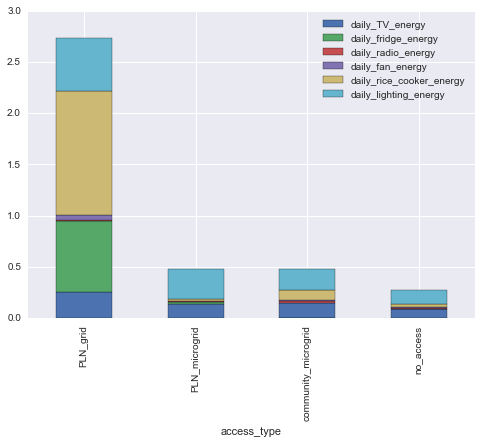

In [11]:
# this should be averall per capita consumption by filling nulls with zeros
energy_data.fillna(0).groupby('access_type').mean().plot(kind='bar', stacked=True)
plt.show()

In [12]:
per_capita_energy_data = energy_data.fillna(0).groupby('access_type').mean()
per_capita_energy_data.index.name = None
per_capita_energy_data

,daily_TV_energy,daily_fridge_energy,daily_radio_energy,daily_fan_energy,daily_rice_cooker_energy,daily_lighting_energy
PLN_grid,0.249333,0.696700,0.008495,0.053808,1.207835,0.522756
PLN_microgrid,0.134622,0.020000,0.007790,0.006050,0.016471,0.294412
community_microgrid,0.148995,0.000000,0.013915,0.008598,0.100000,0.205291
no_access,0.083167,0.003812,0.013377,0.009992,0.020821,0.137055


In [13]:
#per_capita_energy_data.pop('')
#per_capita_energy_data / per_capita_energy_data.sum(axis=1)
per_capita_energy_data.sum()

daily_TV_energy             0.616117
daily_fridge_energy         0.720512
daily_radio_energy          0.043577
daily_fan_energy            0.078448
daily_rice_cooker_energy    1.345127
daily_lighting_energy       1.159513
dtype: float64

We see that as a fraction of total electricity use, lighting diminishes from around 50 percent for microgrid and no grid access to about 20 percent for grid-connected households.

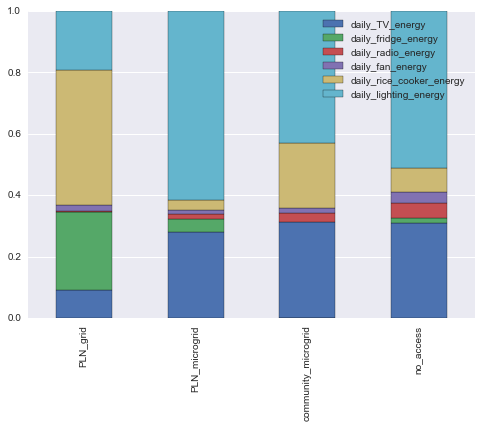

In [14]:
# can I do this normalization by row instead of transposing to do it by column?
#percentages = (per_capita_energy_data.T / per_capita_energy_data.T.sum()).T
percentages = per_capita_energy_data.div(per_capita_energy_data.sum(axis=1), axis=0)
percentages.plot(kind='bar', stacked=True)
plt.show()

In [15]:
# am I having the index label problem here?
aggregated_energy_data = energy_data.fillna(0).groupby('access_type').mean()
aggregated_energy_data['access_type'] = aggregated_energy_data.index
aggregated_energy_data

,daily_TV_energy,daily_fridge_energy,daily_radio_energy,daily_fan_energy,daily_rice_cooker_energy,daily_lighting_energy,access_type
access_type,,,,,,,
PLN_grid,0.249333,0.696700,0.008495,0.053808,1.207835,0.522756,PLN_grid
PLN_microgrid,0.134622,0.020000,0.007790,0.006050,0.016471,0.294412,PLN_microgrid
community_microgrid,0.148995,0.000000,0.013915,0.008598,0.100000,0.205291,community_microgrid
no_access,0.083167,0.003812,0.013377,0.009992,0.020821,0.137055,no_access


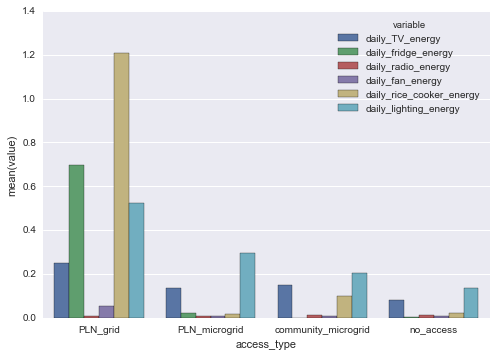

In [16]:
energy_columns = ['daily_TV_energy', 
           'daily_fridge_energy', 
           'daily_radio_energy', 
           'daily_fan_energy', 
           'daily_rice_cooker_energy', 
           'daily_lighting_energy']
tidy_energy_data = pd.melt(aggregated_energy_data, 
                           id_vars='access_type', 
                           value_vars=energy_columns)
sns.barplot(data=tidy_energy_data, x='access_type', hue='variable', y='value')
plt.savefig('energy-by-end-use.png')